In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Veri yolu
train_path = 'C:\\Yazilim\\domates_yaprak\\tomato1\\tomato\\train'
val_path = 'C:\\Yazilim\\domates_yaprak\\tomato1\\tomato\\val'


In [5]:

# Görüntülerin boyutu
img_width, img_height = 224, 224  # DenseNet121 için önerilen boyut

# Veri artırma (data augmentation) işlemi
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Dikey çevirme
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)


In [6]:

# Eğitim verilerini yükleme
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

# Doğrulama verilerini yükleme
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 10000 images belonging to 10 classes.
Found 984 images belonging to 10 classes.


In [7]:

# Sınıf ağırlıklarını hesaplama
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Önceden eğitilmiş DenseNet121 modelini yükleme (ağırlıklar ImageNet veri kümesinden alınmıştır)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Son birkaç katmanı eğitilebilir hale getirin
for layer in densenet_model.layers[-30:]:
    layer.trainable = True


In [8]:

# Modeli oluşturun
model = Sequential()
model.add(densenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

# Modeli derleyin
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               5

In [9]:

# Early stopping ve model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('versiyon11.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)


In [10]:

# Modeli eğitin
history = model.fit(train_generator, epochs=150, validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping, model_checkpoint, reduce_lr])
"""
# Modeli eğitin
history = model.fit(train_generator, epochs=1, validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping, model_checkpoint, reduce_lr])
"""

Epoch 1/150
313/313 [==============================] - 200s 569ms/step - loss: 1.1707 - accuracy: 0.6379 - val_loss: 0.5459 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 2/150
313/313 [==============================] - 81s 258ms/step - loss: 0.3121 - accuracy: 0.8989 - val_loss: 0.1491 - val_accuracy: 0.9502 - lr: 1.0000e-04
Epoch 3/150
313/313 [==============================] - 86s 275ms/step - loss: 0.1988 - accuracy: 0.9332 - val_loss: 0.1297 - val_accuracy: 0.9624 - lr: 1.0000e-04
Epoch 4/150
313/313 [==============================] - 83s 265ms/step - loss: 0.1535 - accuracy: 0.9517 - val_loss: 0.1552 - val_accuracy: 0.9522 - lr: 1.0000e-04
Epoch 5/150
313/313 [==============================] - 84s 268ms/step - loss: 0.1327 - accuracy: 0.9592 - val_loss: 0.0573 - val_accuracy: 0.9888 - lr: 1.0000e-04
Epoch 6/150
313/313 [==============================] - 83s 266ms/step - loss: 0.1178 - accuracy: 0.9618 - val_loss: 0.0754 - val_accuracy: 0.9766 - lr: 1.0000e-04
Epoch 7/150
313/313 [

'\n# Modeli eğitin\nhistory = model.fit(train_generator, epochs=1, validation_data=val_generator, class_weight=class_weights, callbacks=[early_stopping, model_checkpoint, reduce_lr])\n'

In [11]:
# versiyonSon deneme amaçlı yapılmış ve doğru sonucu kaydetmemiştir 
# bestmodel.h5 eskisi ve en iyisidir
model.save("versiyon11.h5")

In [12]:

# Modeli test verileri üzerinde değerlendirin
test_loss, test_accuracy = model.evaluate(val_generator, verbose=2)
print(f"Validation accuracy: {test_accuracy}")


31/31 - 2s - loss: 0.0119 - accuracy: 0.9959 - 2s/epoch - 74ms/step
Validation accuracy: 0.9959349632263184


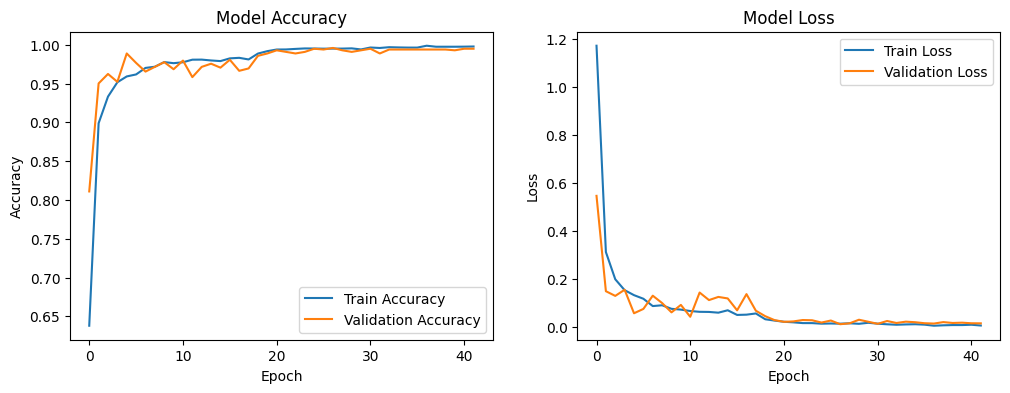

31/31 [==============================] - 4s 75ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      1.00      0.99       100
                        Tomato___Early_blight       1.00      1.00      1.00       100
                         Tomato___Late_blight       1.00      0.99      0.99       100
                           Tomato___Leaf_Mold       1.00      1.00      1.00       100
                  Tomato___Septoria_leaf_spot       1.00      1.00      1.00       100
Tomato___Spider_mites Two-spotted_spider_mite       0.99      1.00      0.99        84
                         Tomato___Target_Spot       1.00      0.99      0.99       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.98      0.99       100
                 Tomato___Tomato_mosaic_virus       1.00      1.00      1.00       100
                             Tomato___healthy       1.00      1.00      1.0

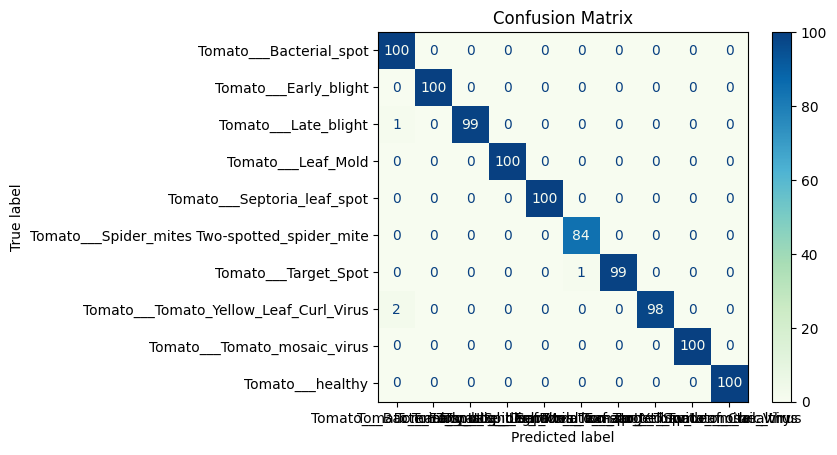

In [13]:

# Eğitim geçmişi grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label='Train Accuracy')
plt.plot(history.history["val_accuracy"], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label='Train Loss')
plt.plot(history.history["val_loss"], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

# Sınıflandırma raporu ve karmaşıklık matrisi
yTestPred = model.predict(val_generator)
yTestPred = np.argmax(yTestPred, axis=1)
yTest = val_generator.classes
class_names = list(val_generator.class_indices.keys())

print(classification_report(yTest, yTestPred, target_names=class_names))

cm = confusion_matrix(yTest, yTestPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.GnBu)
plt.title("Confusion Matrix")
plt.show()
